In [24]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import ticker
import numpy as np
import os
import pandas as pd
from scipy.stats import linregress, pearsonr, spearmanr
import nibabel as nib
import urllib
import seaborn as sns
sns.set_context('notebook', font_scale=2)
sns.set_style('white')


### Read in the phenotypic behavioural data

This is the **Phenotypic_V1_0b_preprocessed1.csv** file. It's saved in the **DATA** folder.

You can find the explanations of all the columns in the **ABIDE_LEGEND_V1.02.pdf** file.

We're going to load the data into a pandas data frame.

In [25]:
behav_data_f = '../../Phenotypic_V1_0b_preprocessed1_HO.csv'
df = pd.read_csv(behav_data_f)

Our measure of interest is **func_perc_fd** so lets get rid of all participants who don't have a value!

We also want to make sure our data **has the data** so lets get rid of all participants who's file ID is "no_filename".

We also want to know the **age in years** for each participant.

In [26]:
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])

### Create a stratified sample

We want to see how similar the average connectivity values are ***when there are no differences between the groups***.

Therefore we need to split participants into ***matched*** samples.

What do they need to be matched on?!

* DSM_IV_TR -- their diagnosis according to the DSM IV (0: control, 1: ASD, 2: Asp, 3: PDD)
* SITE_ID -- the scanning site
* AGE_YRS -- age in years
* SEX -- sex (1: male, 2: female)



### Threshold your sample according to the motion/age cut offs

We're going to systematically change the upper threshold of the percent of volumes that exceed 0.2mm frame to frame dispacement.

And we're also going to select our lower and upper age limits. NOTE that these are inclusive boundaries. So for example a lower limit of 6 and an upper limit of 10 will include participants who are 6, 7, 8, 9 and 10 years old.

* func_perc_fd
* AGE_YRS

In [27]:
motion_thresh = 80
df_samp_motion = df.loc[df['func_perc_fd']<motion_thresh, :]

In [28]:
age_l, age_u = 6, 18
df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l) & (df_samp_motion['AGE_YRS']<=age_u), :]

### Only keep 2n participants

Where n is the number of participants you're going to put in each group.

Remember to shuffle before you do this so you don't keep the top n participant every time.

In [29]:
n = 30
n_2 = 2*n

df_samp_rand = df_samp.reindex(np.random.permutation(df_samp.index))
df_samp_2n = df_samp_rand.iloc[:2*n, :]

### Sort according to the matching measures

In [30]:
sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
df_samp_2n_sorted = df_samp_2n.sort(columns=sort_column_list)

/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


### Split this data frame into two and VOILA

In [31]:
df_grp_A = df_samp_2n_sorted.iloc[::2, :]
df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

### Actually this can be implemented as a function

The inputs to `split_two_matched_samples` are the master data frame (`df`), the motion threshold (`motion_thresh`), lower age limit (`age_l`), upper age limit (`age_u`) and the number of participants (`n`) in each group.

In [62]:
from abide_motion_wrapper_JAL import split_two_matched_samples

df_A, df_B = split_two_matched_samples(df, 10, 6, 18, 20)

print df_A[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()
print df_B[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()


       AGE_AT_SCAN   DX_GROUP        SEX
count    20.000000  20.000000  20.000000
mean     13.394955   1.550000   1.200000
std       2.840967   0.510418   0.410391
min       7.750200   1.000000   1.000000
25%      11.590725   1.000000   1.000000
50%      13.805000   2.000000   1.000000
75%      15.745000   2.000000   1.000000
max      17.830000   2.000000   2.000000
       AGE_AT_SCAN   DX_GROUP        SEX
count    20.000000  20.000000  20.000000
mean     14.411735   1.550000   1.100000
std       2.767167   0.510418   0.307794
min       8.500000   1.000000   1.000000
25%      12.817500   1.000000   1.000000
50%      15.120000   2.000000   1.000000
75%      16.130000   2.000000   1.000000
max      18.010000   2.000000   2.000000


## Getting HO data - only 884 files (out of ~1100) download - for now just working with the 884 files. 
## Cleaned up a phenotypic file to use with the good 884 HO files - Phenotypic_V1_0b_preprocessed1_HO.csv


In [53]:
for f_id in df.loc[:, 'FILE_ID']:
    
    if not (f_id == "no_filename") and not os.path.isfile("../DATA_test/{}_rois_ho.1D".format(f_id)):
        print f_id
        testfile = urllib.URLopener()
    
        testfile.retrieve(("https://s3.amazonaws.com/fcp-indi/data/Projects"
                           "/ABIDE_Initiative/Outputs/cpac/filt_noglobal/rois_ho"
                           "/{}_rois_ho.1D".format(f_id)), 
                              "../DATA_test/{}_rois_ho.1D".format(f_id))

Caltech_0051456


IOError: [Errno 2] No such file or directory: '../DATA_test/Caltech_0051456_rois_ho.1D'

### Make the individual and group correlation matrices

This function is in one of the files in our repository, but I've added in a little check for NaNs.

***TO DO*** Understand better where these NaNs are coming from!

In [63]:
def make_group_corr_mat(df):
    """
    This function reads in each subject's aal roi time series files and creates roi-roi correlation matrices
    for each subject and then sums them all together. The final output is a 3d matrix of all subjects 
    roi-roi correlations, a mean roi-roi correlation matrix and a roi-roi covariance matrix. 
    **NOTE WELL** This returns correlations transformed by the Fisher z, aka arctanh, function.    
    """

    for i, (sub, f_id) in enumerate(df[['SUB_ID', 'FILE_ID']].values):
        
        # read each subjects aal roi time series files
        ts_df = pd.read_table('DATA_HO_cpac_filtnoglobal/{}_rois_ho.1D'.format(f_id))

        # create a correlation matrix from the roi all time series files
        corr_mat_r = ts_df.corr()
        
        # the correlations need to be transformed to Fisher z, which is
        # equivalent to the arctanh function.
        corr_mat_z = np.arctanh(corr_mat_r)
        
        # for the first subject, create a correlation matrix of zeros
        # that is the same dimensions as the aal roi-roi matrix
        if i == 0:
            all_corr_mat = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], len(df)])

        # now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
        all_corr_mat[:, :, i] = corr_mat_z
    
        # If there are any NaNs then print the subject id
        n_nan = np.sum(np.sum(corr_mat_r.isnull()))
        if n_nan > 0:
            print 'SUB has NaNs: {}'.format(f_id)
            
    # create the mean correlation matrix (ignore nas - sometime there are some...)
    av_corr_mat = np.nanmean(all_corr_mat, axis=2)
    # create the group covariance matrix (ignore nas - sometime there are some...)
    var_corr_mat = np.nanvar(all_corr_mat, axis=2)
        
    return all_corr_mat, av_corr_mat, var_corr_mat


Make the group correlation matrices for the two different groups.

Note that the code prints out which subjects have NaNs...

In [64]:
all_corr_mat_A, av_corr_mat_A, var_corr_mat_A = make_group_corr_mat(df_A)
all_corr_mat_B, av_corr_mat_B, var_corr_mat_B = make_group_corr_mat(df_B)


/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in arctanh


SUB has NaNs: SDSU_0050195
SUB has NaNs: UCLA_1_0051272
SUB has NaNs: UM_1_0050336
SUB has NaNs: Yale_0050567
SUB has NaNs: UCLA_1_0051212
SUB has NaNs: UM_1_0050280
SUB has NaNs: Yale_0050605
SUB has NaNs: SDSU_0050211
SUB has NaNs: Yale_0050551
SUB has NaNs: Trinity_0050234


Reason we have nans is because some people have "0" for aal time series - this could be because they don't have coverage there, etc. For example 'Caltech_0051487' has zero for ROI #9052. 

### Check out the distributions of the r and z values in one of the correlation matrices

Just to see what happens to the data when you apply the `arctanh` transform.

(The answer is: not too much!)

## problem with HO data - lots of NaNs!

/Users/Jlnrd/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in arctanh


ValueError: cannot convert float NaN to integer

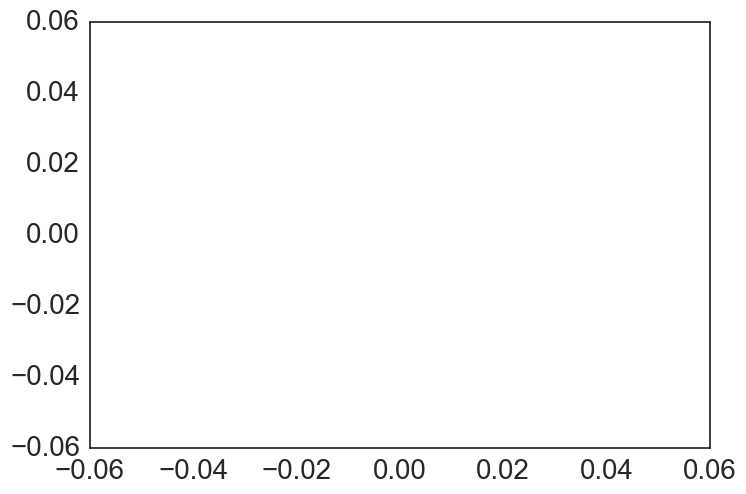

In [56]:
sub, f_id = df[['SUB_ID', 'FILE_ID']].values[0]

ts_df = pd.read_table('DATA_HO_cpac_filtnoglobal/{}_rois_ho.1D'.format(f_id))
corr_mat_r = ts_df.corr()
corr_mat_z = np.arctanh(corr_mat_r)

r_array = np.triu(corr_mat_r, k=1).reshape(-1)
z_array = np.triu(corr_mat_z, k=1).reshape(-1)
sns.distplot(r_array[r_array<>0.0], label='r values')
sns.distplot(z_array[z_array<>0.0], label='z values')

plt.axvline(c='k', linewidth=0.5)

plt.legend()

plt.title('Pairwise correlation values\nfor an example subject')
sns.despine()

## Check 1 average corr mat
### I thought there were only 69 parcellations for HO - confused...When I look at the files they have 111 ROIS

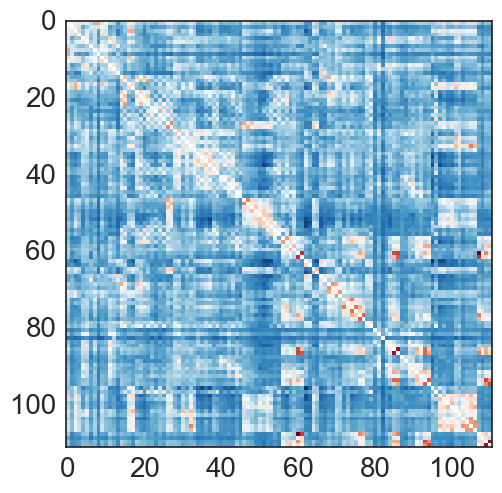

In [65]:
corr_df = pd.read_table('DATA_HO_cpac_filtnoglobal/{}_rois_ho.1D'.format(f_id))

plt.imshow(av_corr_mat_A,interpolation='none', cmap='RdBu_r')

### Visually check the average correlation matrices for the two groups

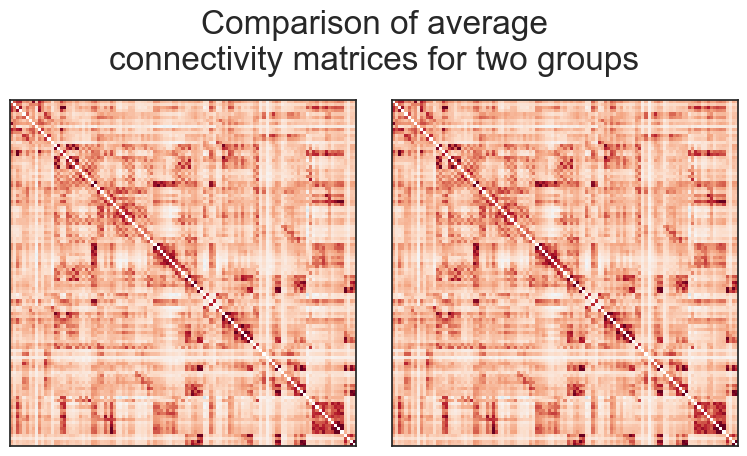

In [66]:
fig, ax_list = plt.subplots(1,2)

ax_list[0].imshow(M_grA_av, interpolation='none', cmap='RdBu_r', vmin=-1, vmax=1)
ax_list[1].imshow(M_grB_av, interpolation='none', cmap='RdBu_r', vmin=-1, vmax=1)

for ax in ax_list:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.suptitle('Comparison of average\nconnectivity matrices for two groups')

plt.tight_layout()


### Scatter plot of the two connectivity matrices 

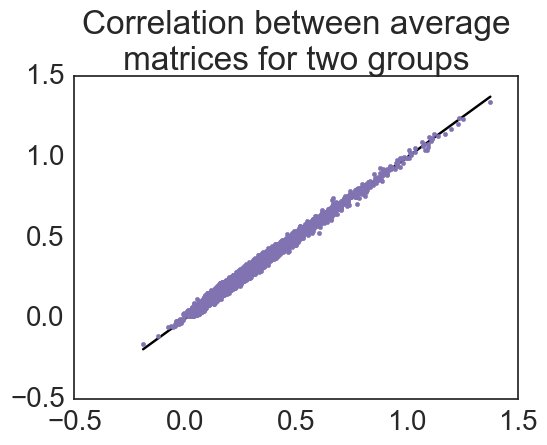

In [67]:
indices = np.triu_indices_from(M_grA_av, k=1)
grA_values = M_grA_av[indices]
grB_values = M_grB_av[indices]

min_val = np.min([np.min(grA_values), np.min(grB_values)])
max_val = np.max([np.max(grA_values), np.max(grB_values)])

fig, ax = plt.subplots(figsize=(6,5))
ax.plot([np.min(grA_values), np.max(grA_values)], [np.min(grA_values), np.max(grA_values)], c='k', zorder=-1)
ax.scatter(grA_values, grB_values, color=sns.color_palette()[3], s=10, edgecolor='face')

ticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(ticks)
ax.yaxis.set_major_locator(ticks)

ax.set_title('Correlation between average\nmatrices for two groups')
plt.tight_layout()

### Calc R squared

We can write a little function for this

In [68]:

def calc_rsq(av_corr_mat_A, av_corr_mat_B):
    """
    From wikipedia: https://en.wikipedia.org/wiki/Coefficient_of_determination
    
    Rsq = 1 - (SSres / SStot)
    
    SSres is calculated as the sum of square errors (where the error
    is the difference between x and y).
    
    SStot is calculated as the total sum of squares in y.
    """
    # Get the data we need
    inds = np.triu_indices_from(av_corr_mat_B, k=1)
    x = av_corr_mat_A[inds]
    y = av_corr_mat_B[inds]
    
    # Calculate the error/residuals
    res = y - x

    SSres = np.sum(res**2)
    
    # Sum up the total error in y
    y_var = y - np.mean(y)
    
    SStot = np.sum(y_var**2)
    
    # R squared
    Rsq = 1 - (SSres/SStot)
    
    return Rsq

In [69]:
Rsq = calc_rsq(av_corr_mat_A, av_corr_mat_B)
Rsq

0.47680339175069308